In [1]:
import matplotlib.pyplot as plt
def plot_to_notebook (time_sec, in_signal, n_samples, out_signal=None):
    plt.figure()
    plt.subplot (1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec [:n_samples]*1e6, in_signal [:n_samples], 'y', label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6, out_signal [:n_samples], 'g-', linewidth=2, label='FIR output')
    plt.legend()

Number of samples:  200000


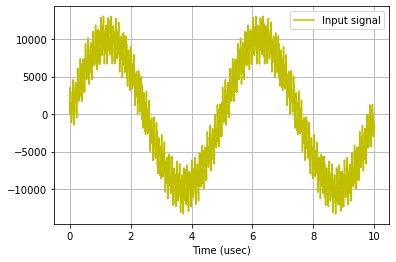

In [3]:
import numpy as np
# Total time
T = 0.002
#Sampling frequency
fs = 100e6
#Number of samples
n = int (T*fs)
#Time vector in seconds
t = np.linspace (0, T, n, endpoint=False)
#Samples of the signal
samples = 10000*np.sin (0.2e6*2*np. pi*t)+ 1500*np.cos (46e6*2*np. pi*t)+ 2000*np.sin (12e6*2*np.pi*t)
# Convert samples to 32-bit integers
samples=samples.astype (np.int32)
print('Number of samples: ',len (samples))
# Plot signal to the notebook
plot_to_notebook (t, samples, 1000)

Software FIR execution time:  0.04294729232788086


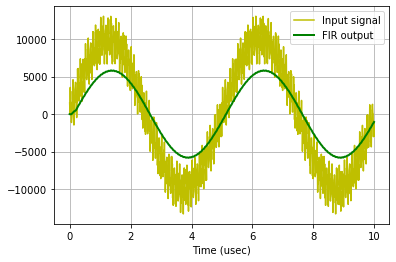

In [4]:
from scipy.signal import lfilter
coeffs=[-255,-260,-312,-288,-144,153,616, 1233, 1963, 2739,3474,4081, 4481, 4620,4481,4081, 3474,2739, 1963, 1233,616,153,-144,-288,-312,260,255]
import time
start_time = time.time()
sw_fir_output = lfilter (coeffs, 70e3, samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print ('Software FIR execution time: ',sw_exec_time)
#Plot the result to notebook
plot_to_notebook (t, samples, 1000, out_signal=sw_fir_output)

In [5]:
from pynq import Overlay
import pynq.lib.dma
# Load the overlay
overlay = Overlay("fir_acc.bit")
# Load the FIR DMA
dma = overlay.fir.fir_dma

Hardware FIR execution time:  0.0034284591674804688
Hardware acceleration factor: 12.526703755215577


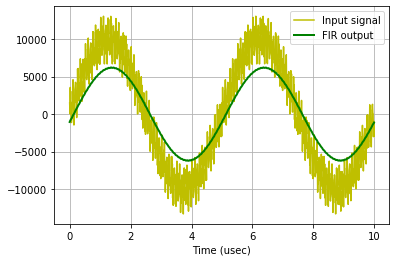

In [9]:
from pynq import allocate
import numpy as np
#Allocate buffers for the input and output signals 
# xink = Xink()
# in_buffer = xlnk.cma_array (shape=(n,), dtype=np.int32) 
# out_buffer = xlnk.cma_array (shape=(n,), dtype=np.int32)
in_buffer = allocate(shape=(n,), 
                           dtype=np.int32, cacheable=1)
out_buffer = allocate(shape=(n,), 
                            dtype=np.int32, cacheable=1)
# Copy the samples to the in_buffer
np.copyto (in_buffer, samples)
# Trigger the DMA transfer and wait for the result import time
start_time = time.time()
dma.sendchannel.transfer (in_buffer)
dma.recvchannel.transfer (out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time=time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time)
print('Hardware acceleration factor:' ,sw_exec_time / hw_exec_time)

# Plot to the notebook
plot_to_notebook (t, samples, 1000, out_signal=out_buffer)
# Free the buffers 
# in_buffer.close() 
# out_buffer.close()
del in_buffer
del out_buffer